In [1]:
# importing the libraries
# basic stuff
import pandas as pd
import numpy as np
import math
import re
import nltk 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer 
from nltk.corpus import stopwords
from tqdm import tqdm
from pymystem3 import Mystem

# nltk stemmers
stemmerRu = SnowballStemmer("russian") 
stemmerEn = PorterStemmer()
# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import normalize



In [2]:
# preprocessing function
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('russian')]
    #lem_words=[Mystem().lemmatize(w) for w in filtered_words]
    #stem_words=[stemmerRu.stem(w) for w in filtered_words]
    return " ".join(filtered_words)




In [3]:
#%time df.to_csv('/Users/apple/BDML/data/trained_clean.csv')
df = pd.read_csv(r'/Users/apple/BDML/data/trained_clean.csv')
df = df.drop(['Unnamed: 0', 'text'], axis = 1)
df.head()

doc_id                                              clean
0       0  открыта вакансия составитель заявок рассмотрим...
1       1  неловкое чувство когдα боишься нαписαть челове...
2       2  нахуй нужна твоё отсутствие жизни делает люди ...
3       3  хотите уходите привыкать брат дома бесuт скуча...
4       4  представляете насколько весы нуждаются тепле л...

In [4]:
import artm


# creating the function for transformation to vowpal_wabbit format

def df_to_vw_regression(df, filepath='in.txt', columns=None, target=None, namespace='clean'):
    if columns is None:
        columns = df.columns.tolist()
    columns.remove(target)

    with open(filepath, 'w') as f:
        for _, row in tqdm(df.iterrows()):
            if namespace:
                f.write('|{0} '.format( namespace))
            else:
                f.write('{0} | '.format(row[target]))
            last_feature = row.index.values[-1]
            for idx, val in row.iteritems():
                if idx not in columns:
                    continue
                if isinstance(val, str):
                    f.write('{0}'.format(val.replace(' ', ' ').replace(':', ' ')))
                elif isinstance(val, float) or isinstance(val, int):
                    if not math.isnan(val):
                        f.write('{0}:{1}'.format(idx.replace(' ', ' ').replace(':', ' '), val))
                    else:
                        continue
                else:
                    f.write('{0}'.format(val.replace(' ', ' ').replace(':', ' ')))
                if idx != last_feature:
                    f.write(' ')
            f.write('\n')



In [5]:
# changing the type of data created
vw = df_to_vw_regression(df, filepath='data_df.txt', target='doc_id')

73987it [00:11, 6417.38it/s]


In [6]:

# batching data for applying it to our model
batch_vectorizer = artm.BatchVectorizer(data_path='data_df.txt',
                                        data_format='vowpal_wabbit',
                                        collection_name='vw',
                                        target_folder='batches2')

#batch_vectorizer = artm.BatchVectorizer(data_path='batches2', data_format='batches')


In [7]:
  # setting up dictionary
dictionary = batch_vectorizer.dictionary

In [8]:
number_of_topics = 60
topic_names = ['topic_{}'.format(i) for i in range(number_of_topics)]

# inial objects creation
model_artm = artm.ARTM(topic_names=topic_names,
                       cache_theta=True,
                       dictionary=dictionary, 
                       seed = 123,
                       show_progress_bars = True)

model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary = dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
#model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',probability_mass_threshold=0.3))
model_artm.scores.add(artm.TopTokensScore(name='top_words',num_tokens = 10))

# additional regulizers
#model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+4))
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparseTheta', tau=- 0.05))
#model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau= 0.3, topic_names= topic_names))#[35:]))

#setting up the number of tokens
model_artm.num_document_passes = 10

#initializing the model we've set up
model_artm.initialize(dictionary=dictionary)

In [9]:
# fitting the model
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=16)

In [10]:
# phi and theta
artm_phi = model_artm.get_phi()
artm_theta = model_artm.get_theta()
## top_tokens
top_tokens = model_artm.score_tracker['top_words']
for topic_name in model_artm.topic_names:
    print ('\n',topic_name)
    for (token, weight) in zip(top_tokens.last_tokens[topic_name][:number_of_topics],top_tokens.last_weights[topic_name][:number_of_topics]):
        print (token, '-', weight)


 topic_0
цена - 0.012518687173724174
наличии - 0.011896701529622078
руб - 0.009832979179918766
цвет - 0.006364926230162382
рублей - 0.005676213651895523
цвета - 0.005186707712709904
заказ - 0.004840675741434097
размер - 0.004179015289992094
размеры - 0.003917711786925793
материал - 0.003542603924870491

 topic_1
срок - 0.009537865407764912
лет - 0.008417376317083836
доставка - 0.00642100814729929
года - 0.005376916844397783
права - 0.0050798868760466576
дней - 0.00481716962531209
размере - 0.0045396084897220135
случае - 0.004088984336704016
суд - 0.003982222639024258
рублей - 0.003683654125779867

 topic_2
день - 0.013244854286313057
сегодня - 0.011520987376570702
стоит - 0.005784452427178621
дня - 0.0045004175044596195
постарайтесь - 0.0044370414689183235
отношения - 0.004127826076000929
работа - 0.0035052532330155373
возможно - 0.003435309510678053
дела - 0.0030528404749929905
здоровье - 0.0030412585474550724

 topic_3
делать - 0.007886341772973537
вопрос - 0.0063435593619942665
лет

In [11]:
perplexityScore = list(model_artm.score_tracker['PerplexityScore'].value)
perplexityScore[1:]

[45385.0078125,
 36760.30078125,
 27436.490234375,
 22631.609375,
 20470.80078125,
 19365.294921875,
 18712.873046875,
 18284.42578125,
 17989.322265625,
 17781.9296875,
 17631.337890625,
 17517.92578125,
 17430.171875,
 17360.501953125,
 17304.236328125]

Text(0, 0.5, 'perplexity score')

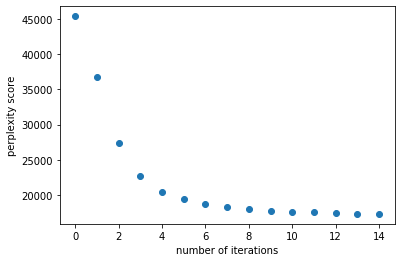

In [12]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

# visualizing perplexity [1:]
plt.scatter(range(len(perplexityScore[1:])), perplexityScore[1:])
plt.xlabel('number of iterations')
plt.ylabel('perplexity score')

Text(0, 0.5, 'perplexity score')

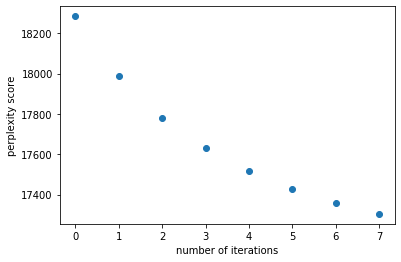

In [13]:
plt.scatter(range(len(perplexityScore[8:])), perplexityScore[8:])
plt.xlabel('number of iterations')
plt.ylabel('perplexity score')

In [14]:
lables = dict()
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist


# lemmatisation of top tokens

for topic_name in model_artm.topic_names:
    
    lables[topic_name] = ' '.join(word for word in top_tokens.last_tokens[topic_name][0:6])
    lables[topic_name] = ''.join(Mystem().lemmatize(lables[topic_name]))
    lables[topic_name] = ' '.join(unique_list(lables[topic_name].split()))
    
    print(lables[topic_name])
    
    artm_theta.rename({topic_name:lables[topic_name]}, inplace = True)

    
lables

цена наличие руб цвет рубль
срок год доставка право день
день сегодня стоять постараться отношение
делать вопрос год поэтому часто ставить
игра матч футбол команда мир
гороскоп сегодня рождаться июнь август июль
радоваться бог господь христос
область год россия район город дтп
хотеть лайк нахуй любить блять репост
ребенок жизнь
деньги день человек жизнь год
год век дизайн место дом музей
озеро город мир метр остров парк
волос sex big tits anal
что это как так я ты
від ціна або але характеристика буде
iphone apple видео новый android google
человек жизнь ремарк
альбом amp love рок группа
руб работа тело требоваться дом квартира
человек бизнес жизнь должный
год мама сказать говорить дверь домой
день нога мышца упражнение тело
почему сегодня день делать знать говорить
минута масло вода затем добавлять
ученый год иметь собака длина
хотеть любовь друг жизнь рядом
человек лишь смерть мир
несколько становиться дома снова смерть
человек имя энергия деньги жизнь сила
год сша нью
человек любить 

{'topic_0': 'цена наличие руб цвет рубль',
 'topic_1': 'срок год доставка право день',
 'topic_2': 'день сегодня стоять постараться отношение',
 'topic_3': 'делать вопрос год поэтому часто ставить',
 'topic_4': 'игра матч футбол команда мир',
 'topic_5': 'гороскоп сегодня рождаться июнь август июль',
 'topic_6': 'радоваться бог господь христос',
 'topic_7': 'область год россия район город дтп',
 'topic_8': 'хотеть лайк нахуй любить блять репост',
 'topic_9': 'ребенок жизнь',
 'topic_10': 'деньги день человек жизнь год',
 'topic_11': 'год век дизайн место дом музей',
 'topic_12': 'озеро город мир метр остров парк',
 'topic_13': 'волос sex big tits anal',
 'topic_14': 'что это как так я ты',
 'topic_15': 'від ціна або але характеристика буде',
 'topic_16': 'iphone apple видео новый android google',
 'topic_17': 'человек жизнь ремарк',
 'topic_18': 'альбом amp love рок группа',
 'topic_19': 'руб работа тело требоваться дом квартира',
 'topic_20': 'человек бизнес жизнь должный',
 'topic_21

In [15]:
artm_theta.head()

63000         63001  \
цена наличие руб цвет рубль                0.000013  2.487670e-02   
срок год доставка право день               0.000091  1.359652e-07   
день сегодня стоять постараться отношение  0.000119  2.277124e-03   
делать вопрос год поэтому часто ставить    0.004369  1.207722e-04   
игра матч футбол команда мир               0.000047  4.432864e-02   

                                                  63002         63003  \
цена наличие руб цвет рубль                1.894090e-05  4.180943e-08   
срок год доставка право день               4.774458e-03  7.203462e-07   
день сегодня стоять постараться отношение  2.651228e-07  6.395367e-05   
делать вопрос год поэтому часто ставить    1.919877e-06  1.765726e-04   
игра матч футбол команда мир               3.786345e-07  2.704719e-05   

                                                  63004     63005  \
цена наличие руб цвет рубль                4.677451e-04  0.006309   
срок год доставка право день               3.782903e-07  0.020393   
день сегодня стоять постараться отношение  9.776939e-03  0.056738   
делать вопрос год поэтому часто ставить    9.080915e-04  0.009231   
игра матч футбол команда мир               4.186845e-02  0.000805   

                                                  63006     63007  \
цена наличие руб цвет рубль                7.295858e-06  0.001046   
срок год доставка право день               9.225982e-09  0.000044   
день сегодня стоять постараться отношение  1.627776e-08  0.004024   
делать вопрос год поэтому часто ставить    1.315548e-06  0.000006   
игра матч футбол команда мир               1.442759e-03  0.000235   

                                                  63008         63009  ...  \
цена наличие руб цвет рубль                3.208535e-03  5.124904e-09  ...   
срок год доставка право день               7.858826e-03  1.728282e-04  ...   
день сегодня стоять постараться отношение  4.025530e-06  1.169661e-02  ...   
делать вопрос год поэтому часто ставить    1.726217e-07  4.962819e-02  ...   
игра матч футбол команда мир               8.773404e-11  1.582295e-01  ...   

                                                  5990      5991   \
цена наличие руб цвет рубль                1.586715e-08  0.022241   
срок год доставка право день               5.164471e-05  0.017537   
день сегодня стоять постараться отношение  8.825723e-04  0.003452   
делать вопрос год поэтому часто ставить    7.969682e-02  0.301545   
игра матч футбол команда мир               5.815114e-06  0.000047   

                                                  5992      5993      5994   \
цена наличие руб цвет рубль                7.156348e-09  0.000996  0.002756   
срок год доставка право день               5.675112e-07  0.000031  0.004009   
день сегодня стоять постараться отношение  7.522944e-03  0.007065  0.003562   
делать вопрос год поэтому часто ставить    1.521311e-07  0.003039  0.003318   
игра матч футбол команда мир               5.265379e-04  0.265525  0.002752   

                                                  5995      5996   \
цена наличие руб цвет рубль                1.268640e-01  0.000132   
срок год доставка право день               2.088579e-08  0.002789   
день сегодня стоять постараться отношение  2.479342e-06  0.000193   
делать вопрос год поэтому часто ставить    6.692590e-04  0.002550   
игра матч футбол команда мир               2.598712e-02  0.000583   

                                                  5997          5998   \
цена наличие руб цвет рубль                1.969292e-07  1.220426e-05   
срок год доставка право день               9.007227e-09  1.026683e-06   
день сегодня стоять постараться отношение  3.870480e-03  1.324207e-03   
делать вопрос год поэтому часто ставить    2.576829e-04  1.636833e-03   
игра матч футбол команда мир               7.490623e-07  6.193480e-08   

                                                  5999   
цена наличие руб цвет рубль                2.344988e-08  
срок год доставка право день     

In [218]:
theta_transposed = artm_theta.transpose()
theta_transposed.head()

цена наличие руб цвет рубль  срок год доставка право день  \
63000                 1.283489e-05                  9.054475e-05   
63001                 2.487670e-02                  1.359652e-07   
63002                 1.894090e-05                  4.774458e-03   
63003                 4.180943e-08                  7.203462e-07   
63004                 4.677451e-04                  3.782903e-07   

       день сегодня стоять постараться отношение  \
63000                               1.186634e-04   
63001                               2.277124e-03   
63002                               2.651228e-07   
63003                               6.395367e-05   
63004                               9.776939e-03   

       делать вопрос год поэтому часто ставить  игра матч футбол команда мир  \
63000                                 0.004369                  4.670382e-05   
63001                                 0.000121                  4.432864e-02   
63002                                 0.000002                  3.786345e-07   
63003                                 0.000177                  2.704719e-05   
63004                                 0.000908                  4.186845e-02   

       гороскоп сегодня рождаться июнь август июль  \
63000                                     0.001165   
63001                                     0.111401   
63002                                     0.000004   
63003                                     0.000054   
63004                                     0.029830   

       радоваться бог господь христос  область год россия район город дтп  \
63000                    7.244105e-09                        2.221060e-01   
63001                    6.272715e-07                        3.313401e-05   
63002                    9.135210e-06                        2.091568e-05   
63003                    1.767482e-05                        7.772203e-07   
63004                    3.492756e-06                        4.085260e-03   

       хотеть лайк нахуй любить блять репост  ребенок жизнь  ...  \
63000                           2.473884e-05       0.000005  ...   
63001                           2.293611e-03       0.000111  ...   
63002                           1.105969e-04       0.000048  ...   
63003                           1.674301e-03       0.000171  ...   
63004                           2.821428e-07       0.003212  ...   

       продавать цена размер руб отдавать состояние  \
63000                                  2.083673e-10   
63001                                  3.923129e-03   
63002                                  1.174189e-03   
63003                                  1.308108e-03   
63004                                  4.687210e-05   

       грн являться мир габардин жизнь льон  человек жизнь сегодня жить лишь  \
63000                          2.415646e-04                     5.558180e-08   
63001                          1.686856e-06                     1.222925e-03   
63002                          1.145531e-08                     9.388851e-03   
63003                          2.162830e-06                     3.476221e-02   
63004                          1.413770e-01                     2.451302e-02   

       bmw ряд петля mercedes лицо ford  \
63000                      7.256137e-10   
63001                      1.418723e-05   
63002                      7.048913e-09   
63003                      3.858665e-03   
63004                      1.703124e-07   

       например поэтому работа время несколько часто  \
63000                                       0.002181   
63001                                       0.000722   
63002                                       0.000049   
63003                                       0.000005   
63004                                       0.002036   

       жанр que драма режиссер роль não  \
63000                      7.784645e-09   
63001                      4.110606e-13   
63002                      1.339524e-03   
63003                      

In [219]:

odd_themes = [
            'человек именно часто являться',
            'человек жизнь сегодня жить лишь',
            'человек жизнь значит твой',
            'сегодня друг день группа утро добрый',
            'человек любить жизнь',
            'александр год работа сергей андрей',
            'ребенок жизнь',
            'руб amp вылет день ночь завтрак',
            'человек лишь смерть мир',
            'что это как так я ты',
            'год сша нью',
            'ученый год иметь собака длина',
            'срок год доставка право день',
            'день сегодня стоять постараться отношение',
            'волос sex big tits anal',
            'жанр que драма режиссер роль não',
            'почему сегодня день делать знать говорить',
            'деньги день человек жизнь год',
            'грн являться мир габардин жизнь льон',
            'делать вопрос год поэтому часто ставить',
            'несколько становиться дома снова смерть'
    ]



theta_transposed.drop(odd_themes,axis = 1, inplace = True)

theta_transposed.to_csv('theta_transposed.csv')

doc_id                                              clean  \
0       0  открыта вакансия составитель заявок рассмотрим...   
1       1  неловкое чувство когдα боишься нαписαть челове...   
2       2  нахуй нужна твоё отсутствие жизни делает люди ...   
3       3  хотите уходите привыкать брат дома бесuт скуча...   
4       4  представляете насколько весы нуждаются тепле л...   

                                         theme      coef  
0     руб работа тело требоваться дом квартира  0.916754  
1               хотеть любовь друг жизнь рядом  0.216467  
2        хотеть лайк нахуй любить блять репост  0.602400  
3        хотеть лайк нахуй любить блять репост  0.367068  
4  гороскоп сегодня рождаться июнь август июль  0.157437

In [4]:
theta_transposed = pd.read_csv(r'theta_transposed.csv').drop(['Unnamed: 0'], axis = 1)
df['theme'] = theta_transposed.idxmax(axis=1)
df['coef'] = 1 #theta_transposed.max(axis = 1)
df.head()

KeyError: "['text'] not found in axis"

In [220]:
group_user = pd.read_csv(r'/Users/apple/BDML/data/group_user.csv').rename(columns = {'group':'group_id'})
lables = pd.read_csv(r'/Users/apple/BDML/data/train_ids.csv').rename(columns = {'_id':'group_id'})

In [221]:
lables.tail()

doc_id  group_id
73982   73982       -49
73983   73983       -31
73984   73984       -24
73985   73985       -18
73986   73986       -13

In [222]:
df = df.merge(lables, on = 'doc_id')
df.tail()

doc_id                                              clean  \
73982   73982  срочная чистка красных партизан вашем присутст...   
73983   73983  утренний обзор сегодня известные любителям сиг...   
73984   73984  сегодня балконный вечерний котэ выехали коттед...   
73985   73985  почему девочка злится противоречивая женская н...   
73986   73986  дождливый день сделать прекрасные фотографии о...   

                                                   theme      coef  group_id  
73982           руб работа тело требоваться дом квартира  0.308435       -49  
73983                  минута масло вода затем добавлять  0.128923       -31  
73984  здравствовать пожалуйста подсказывать сколько ...  0.261705       -24  
73985                  минута масло вода затем добавлять  0.235368       -18  
73986    фото фотография фотограф свадьба художник автор  0.335062       -13

In [223]:
interests = group_user \
    .merge(df, on = 'group_id' ) \
    .drop(['clean', 'doc_id', 'group_id'], axis = 1) \
    .sort_values('user')


In [224]:
interests = interests \
    .reset_index() \
    .pivot_table(index = 'user', columns='theme') \
    .replace(np.nan, 0) 

In [225]:
interests.columns = interests.columns.get_level_values(1)
interests.columns = [''.join(col).strip() for col in interests.columns.values]
interests.tail(30)

bmw ряд петля mercedes лицо ford  \
user                                          
440144209                          0.000000   
440153261                          0.000000   
440184247                          0.000000   
440366514                          0.000000   
440496039                          0.000000   
440591364                          0.000000   
440928808                          0.000000   
440976066                          0.000000   
441102910                          0.000000   
441120732                          0.000000   
441217423                          0.000000   
441314164                          0.000000   
441339414                          0.000000   
441461003                          0.000000   
441566330                          0.000000   
441579113                          0.122502   
441764935                          0.000000   
441873957                          0.000000   
441933226                          0.000000   
442401256                          0.000000   
442574664                          0.000000   
442847876                          0.000000   
442881491                          0.000000   
442904635                          0.000000   
442971935                          0.000000   
443148104                          0.000000   
443202777                          0.000000   
443212325                          0.000000   
443331124                          0.000000   
443374184                          0.000000   

           iphone apple видео новый android google  \
user                                                 
440144209                                 0.000000   
440153261                                 0.000000   
440184247                                 0.000000   
440366514                                 0.000000   
440496039                                 0.000000   
440591364                                 0.000000   
440928808                                 0.000000   
440976066                                 0.000000   
441102910                                 0.000000   
441120732                                 0.000000   
441217423                                 0.000000   
441314164                                 0.000000   
441339414                                 0.000000   
441461003                                 0.000000   
441566330                                 0.000000   
441579113                                 0.000000   
441764935                                 0.000000   
441873957                                 0.000000   
441933226                                 0.000000   
442401256                                 0.000000   
442574664                                 0.000000   
442847876                                 0.000000   
442881491                                 0.000000   
442904635                                 0.000000   
442971935                                 0.000000   
443148104                                 0.000000   
443202777                                 0.000000   
443212325                                 0.000000   
443331124                                 0.242489   
443374184                                 0.000000   

           альбом amp love рок группа  від ціна або але характеристика буде  \
user                                                                          
440144209                    0.000000                              0.000000   
440153261                    0.000000                              0.000000   
440184247                    0.000000                              0.000000   
440366514                    0.000000                              0.000000   
440496039                    0.000000                              0.000000   
440591364                    0.000000                              0.000000   
440928808                    0.000000                              0.000000   
440976066                    0.000000                             

In [226]:
# creating age groups
vk_user = pd.read_csv(r'/Users/apple/BDML/data/vk_profiles.csv')
age_sex = vk_user.loc[:, :'sex'].rename(columns = {'id': 'user'})
age_sex['age_group'] = pd.cut(age_sex.age, [0, 14, 20, 27, 36, 45, 54, 63, 72, 81])
#age_sex.head()

cut = age_sex
cut['count'] = 1
cut.pivot_table('count', index='age_group', columns='sex', aggfunc='sum')


sex           0     1
age_group            
(0, 14]       8     5
(14, 20]     64    88
(20, 27]   2676  2713
(27, 36]   5910  8152
(36, 45]   5091  7581
(45, 54]   3518  4123
(54, 63]   2585  2098
(63, 72]    830   525
(72, 81]     80    94

In [227]:
groups = age_sex.loc[:,'age_group'].unique().astype(str)
age_sex['age_group'] = age_sex['age_group'].astype(str)

In [228]:
grouping = dict()
ingroup_clusters = dict()
for o in range(2):
    for i in groups:
        
        grouping[str(i)+"_"+str(o)] = age_sex \
            .loc[(age_sex['sex'] == o) & (age_sex['age_group'] == i)]
        
        
        grouping[str(i)+"_"+str(o)] = grouping[str(i)+"_"+str(o)].merge(interests, on = 'user')
        

In [229]:
grouping['(36.0, 45.0]_1'].loc[:, (grouping['(36.0, 45.0]_1'] != 0).any(axis=0)].head(10)

user  age  sex     age_group  count  bmw ряд петля mercedes лицо ford  \
0    176   37    1  (36.0, 45.0]      1                               0.0   
1    200   37    1  (36.0, 45.0]      1                               0.0   
2    252   39    1  (36.0, 45.0]      1                               0.0   
3   1221   43    1  (36.0, 45.0]      1                               0.0   
4   5463   38    1  (36.0, 45.0]      1                               0.0   
5  10236   38    1  (36.0, 45.0]      1                               0.0   
6  12962   38    1  (36.0, 45.0]      1                               0.0   
7  15158   39    1  (36.0, 45.0]      1                               0.0   
8  19865   39    1  (36.0, 45.0]      1                               0.0   
9  20665   39    1  (36.0, 45.0]      1                               0.0   

   iphone apple видео новый android google  альбом amp love рок группа  \
0                                 0.309464                    0.000000   
1                                 0.000000                    0.266945   
2                                 0.000000                    0.000000   
3                                 0.000000                    0.000000   
4                                 0.239515                    0.000000   
5                                 0.185880                    0.324738   
6                                 0.000000                    0.000000   
7                                 0.000000                    0.000000   
8                                 0.000000                    0.000000   
9                                 0.407363                    0.000000   

   від ціна або але характеристика буде  год век дизайн место дом музей  ...  \
0                                   0.0                        0.000000  ...   
1                                   0.0                        0.408278  ...   
2                                   0.0                        0.000000  ...   
3                                   0.0                        0.000000  ...   
4                                   0.0                        0.000000  ...   
5                                   0.0                        0.485261  ...   
6                                   0.0                        0.322849  ...   
7                                   0.0                        0.000000  ...   
8                                   0.0                        0.000000  ...   
9                                   0.0                        0.000000  ...   

   сердце любовь жизнь мир лишь  серия сезон видео фильм онлайн смотреть  \
0                           0.0                                      0.0   
1                           0.0                                      0.0   
2                           0.0                                      0.0   
3                           0.0                                      0.0   
4                           0.0                                      0.0   
5                      593799.0                                      0.0   
6                           0.0                                      0.0   
7                           0.0                                      0.0   
8                      549276.0                                      0.0   
9                           0.0                                      0.0   

   фото фотография фотограф свадьба художник автор  \
0                                              0.0   
1                                         278168.0   
2                                              0.0   
3                                         705000.0   
4                                              0.0   
5                                          10936.0   
6                                              0.0   
7                                              0.0   
8                                              0.0   
9                                              0.0   

   хотеть лайк нахуй любить 

In [230]:
for a in grouping:
    ingroup_clusters[a] = AgglomerativeClustering(n_clusters=4,affinity='euclidean',linkage='ward') \
        .fit(grouping[a].drop(columns = ['user','age','sex','age_group','count']))
    grouping[a]['ag_lables'] = ingroup_clusters[a].labels_
    # for b in range(4):
        # grouping[a].loc[grouping[a]['ag_lables'] == b]

## Мужчины от 36 до 45 включительно кластер 2

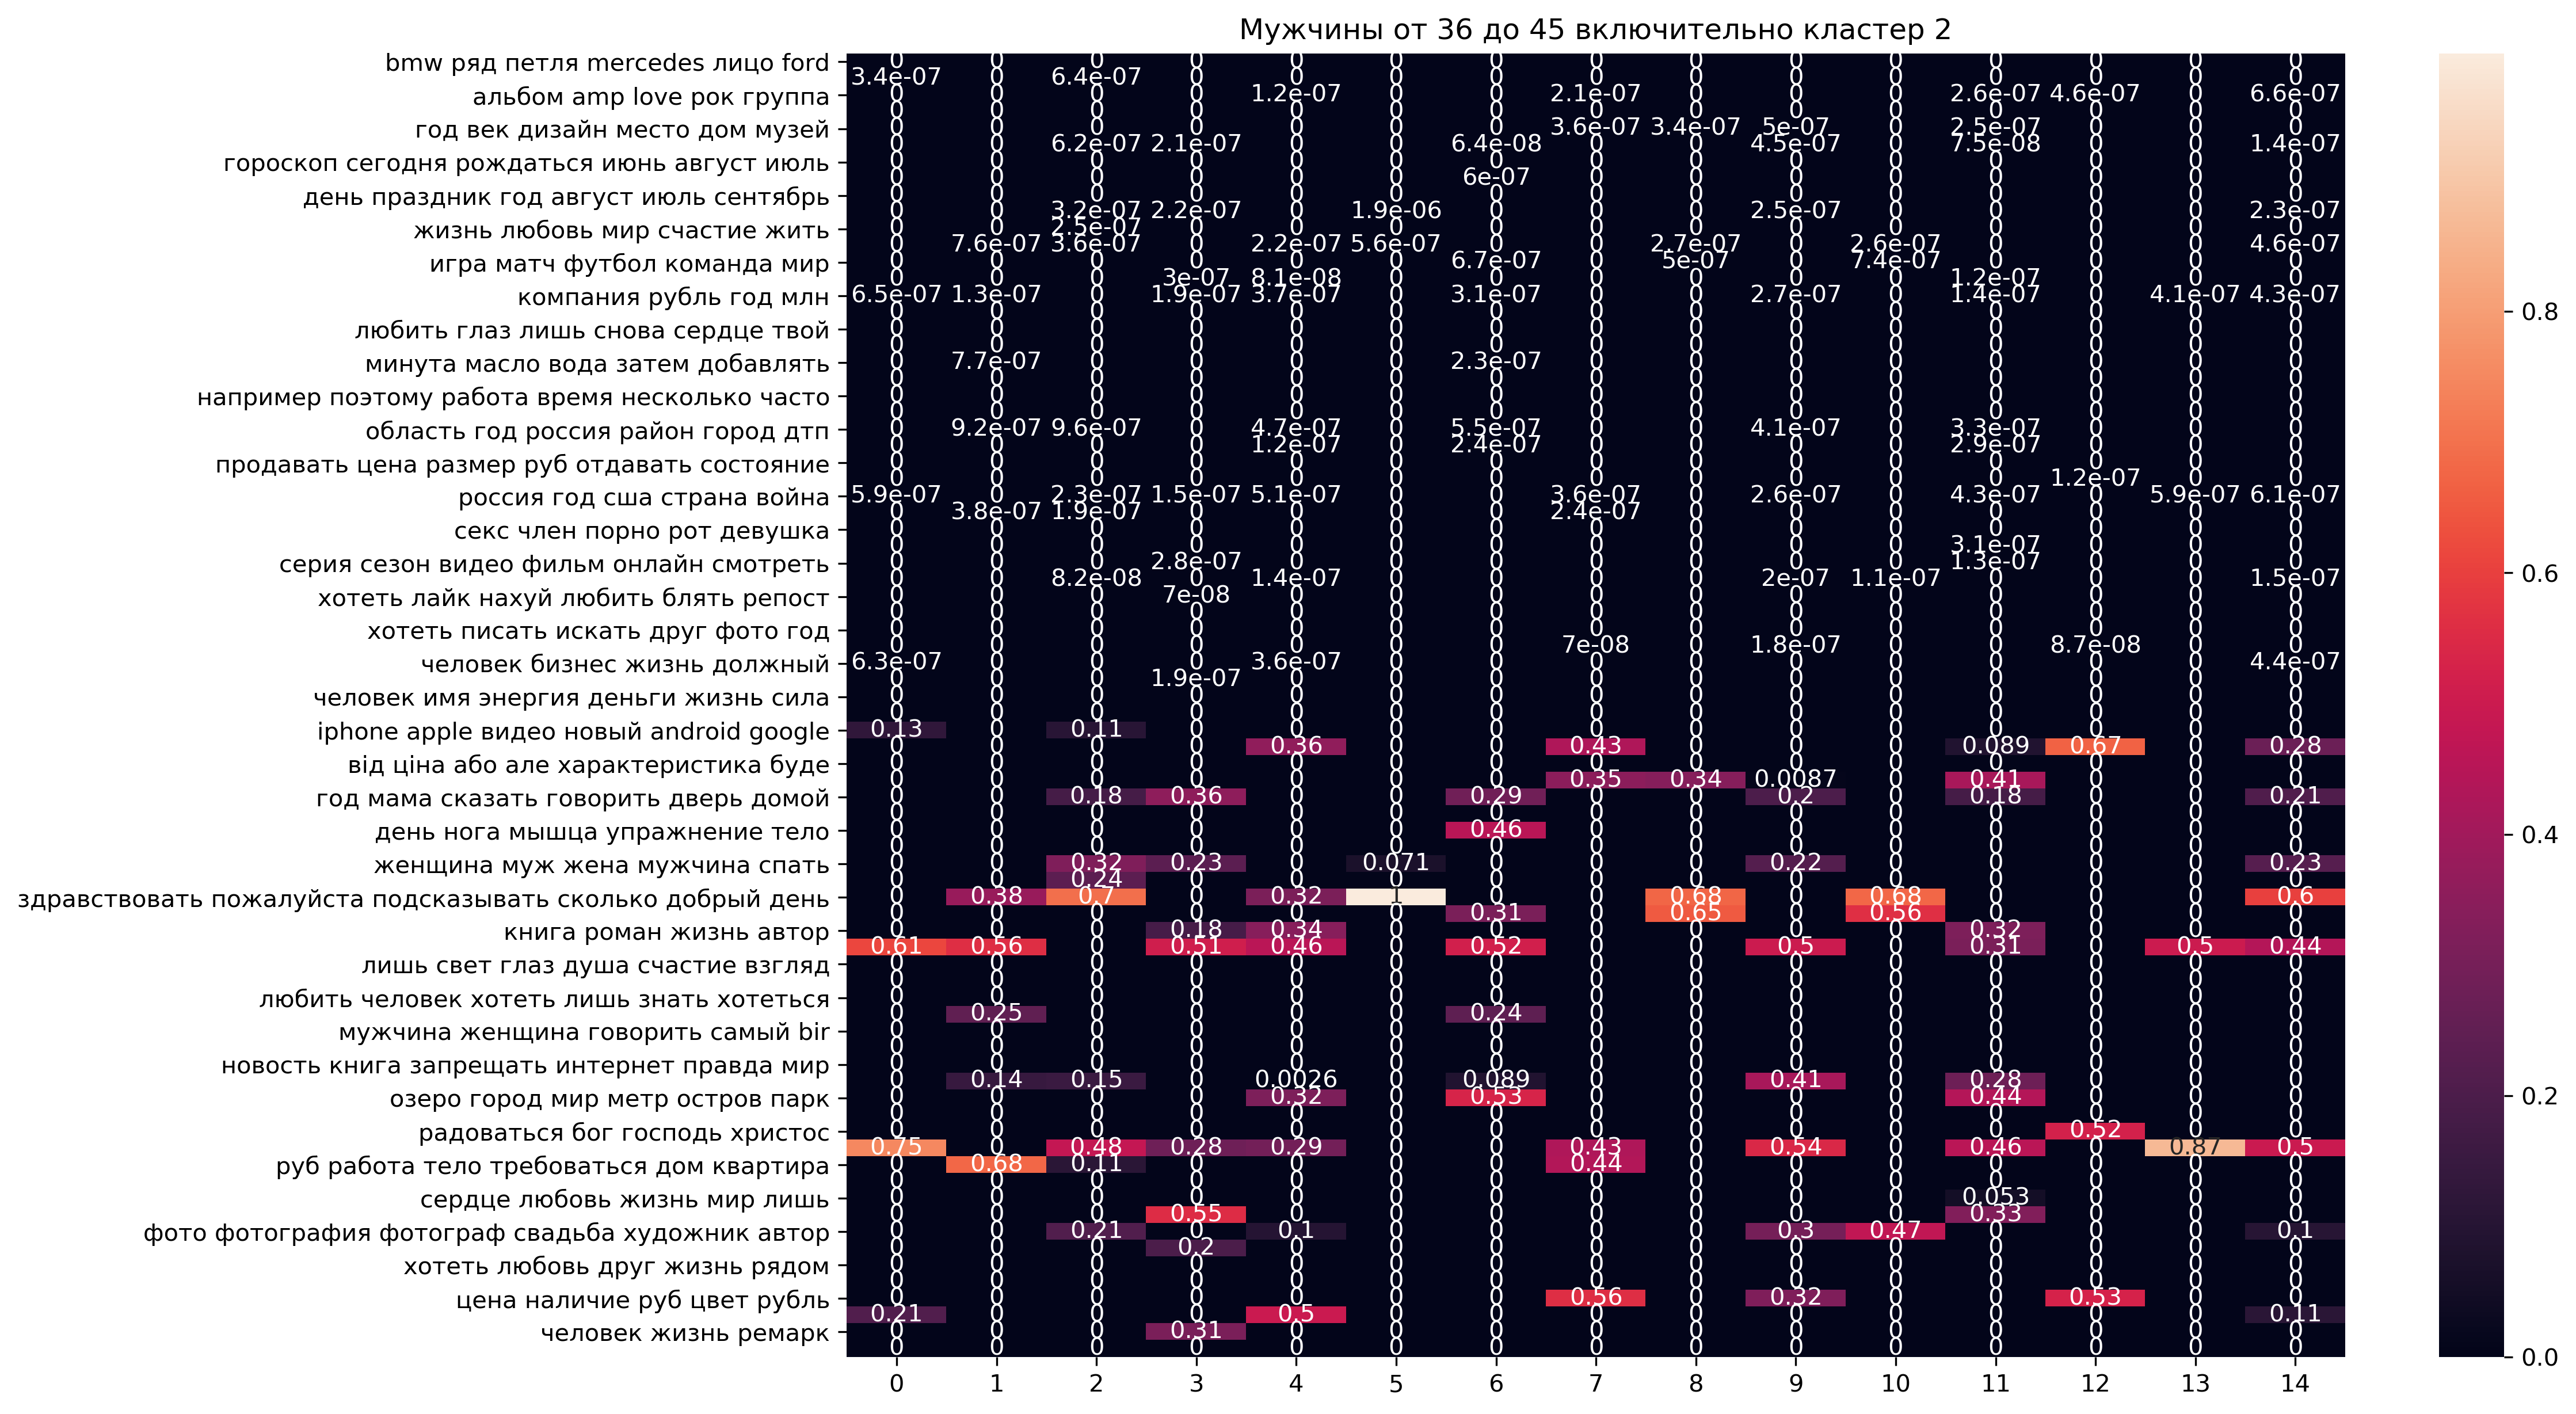

In [239]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 10), dpi=300)
scaler = normalize(grouping['(36.0, 45.0]_1'] \
                   .drop(columns = ['user','age','sex','age_group','count']) \
                   .loc[grouping['(36.0, 45.0]_1']['ag_lables'] == 2] \
                   .drop(columns = 'ag_lables')
                   .iloc[:15,:], norm = 'l2')
a = pd.DataFrame(scaler)
a.columns = grouping['(36.0, 45.0]_1'].drop(columns = ['user','age','sex','age_group','count', 'ag_lables']).columns
ax = plt.axes()
ax.set_title('Мужчины от 36 до 45 включительно кластер 2')
sb.heatmap(a.T, annot = True)

## Мужчины от 20 до 27 включительно кластер 1

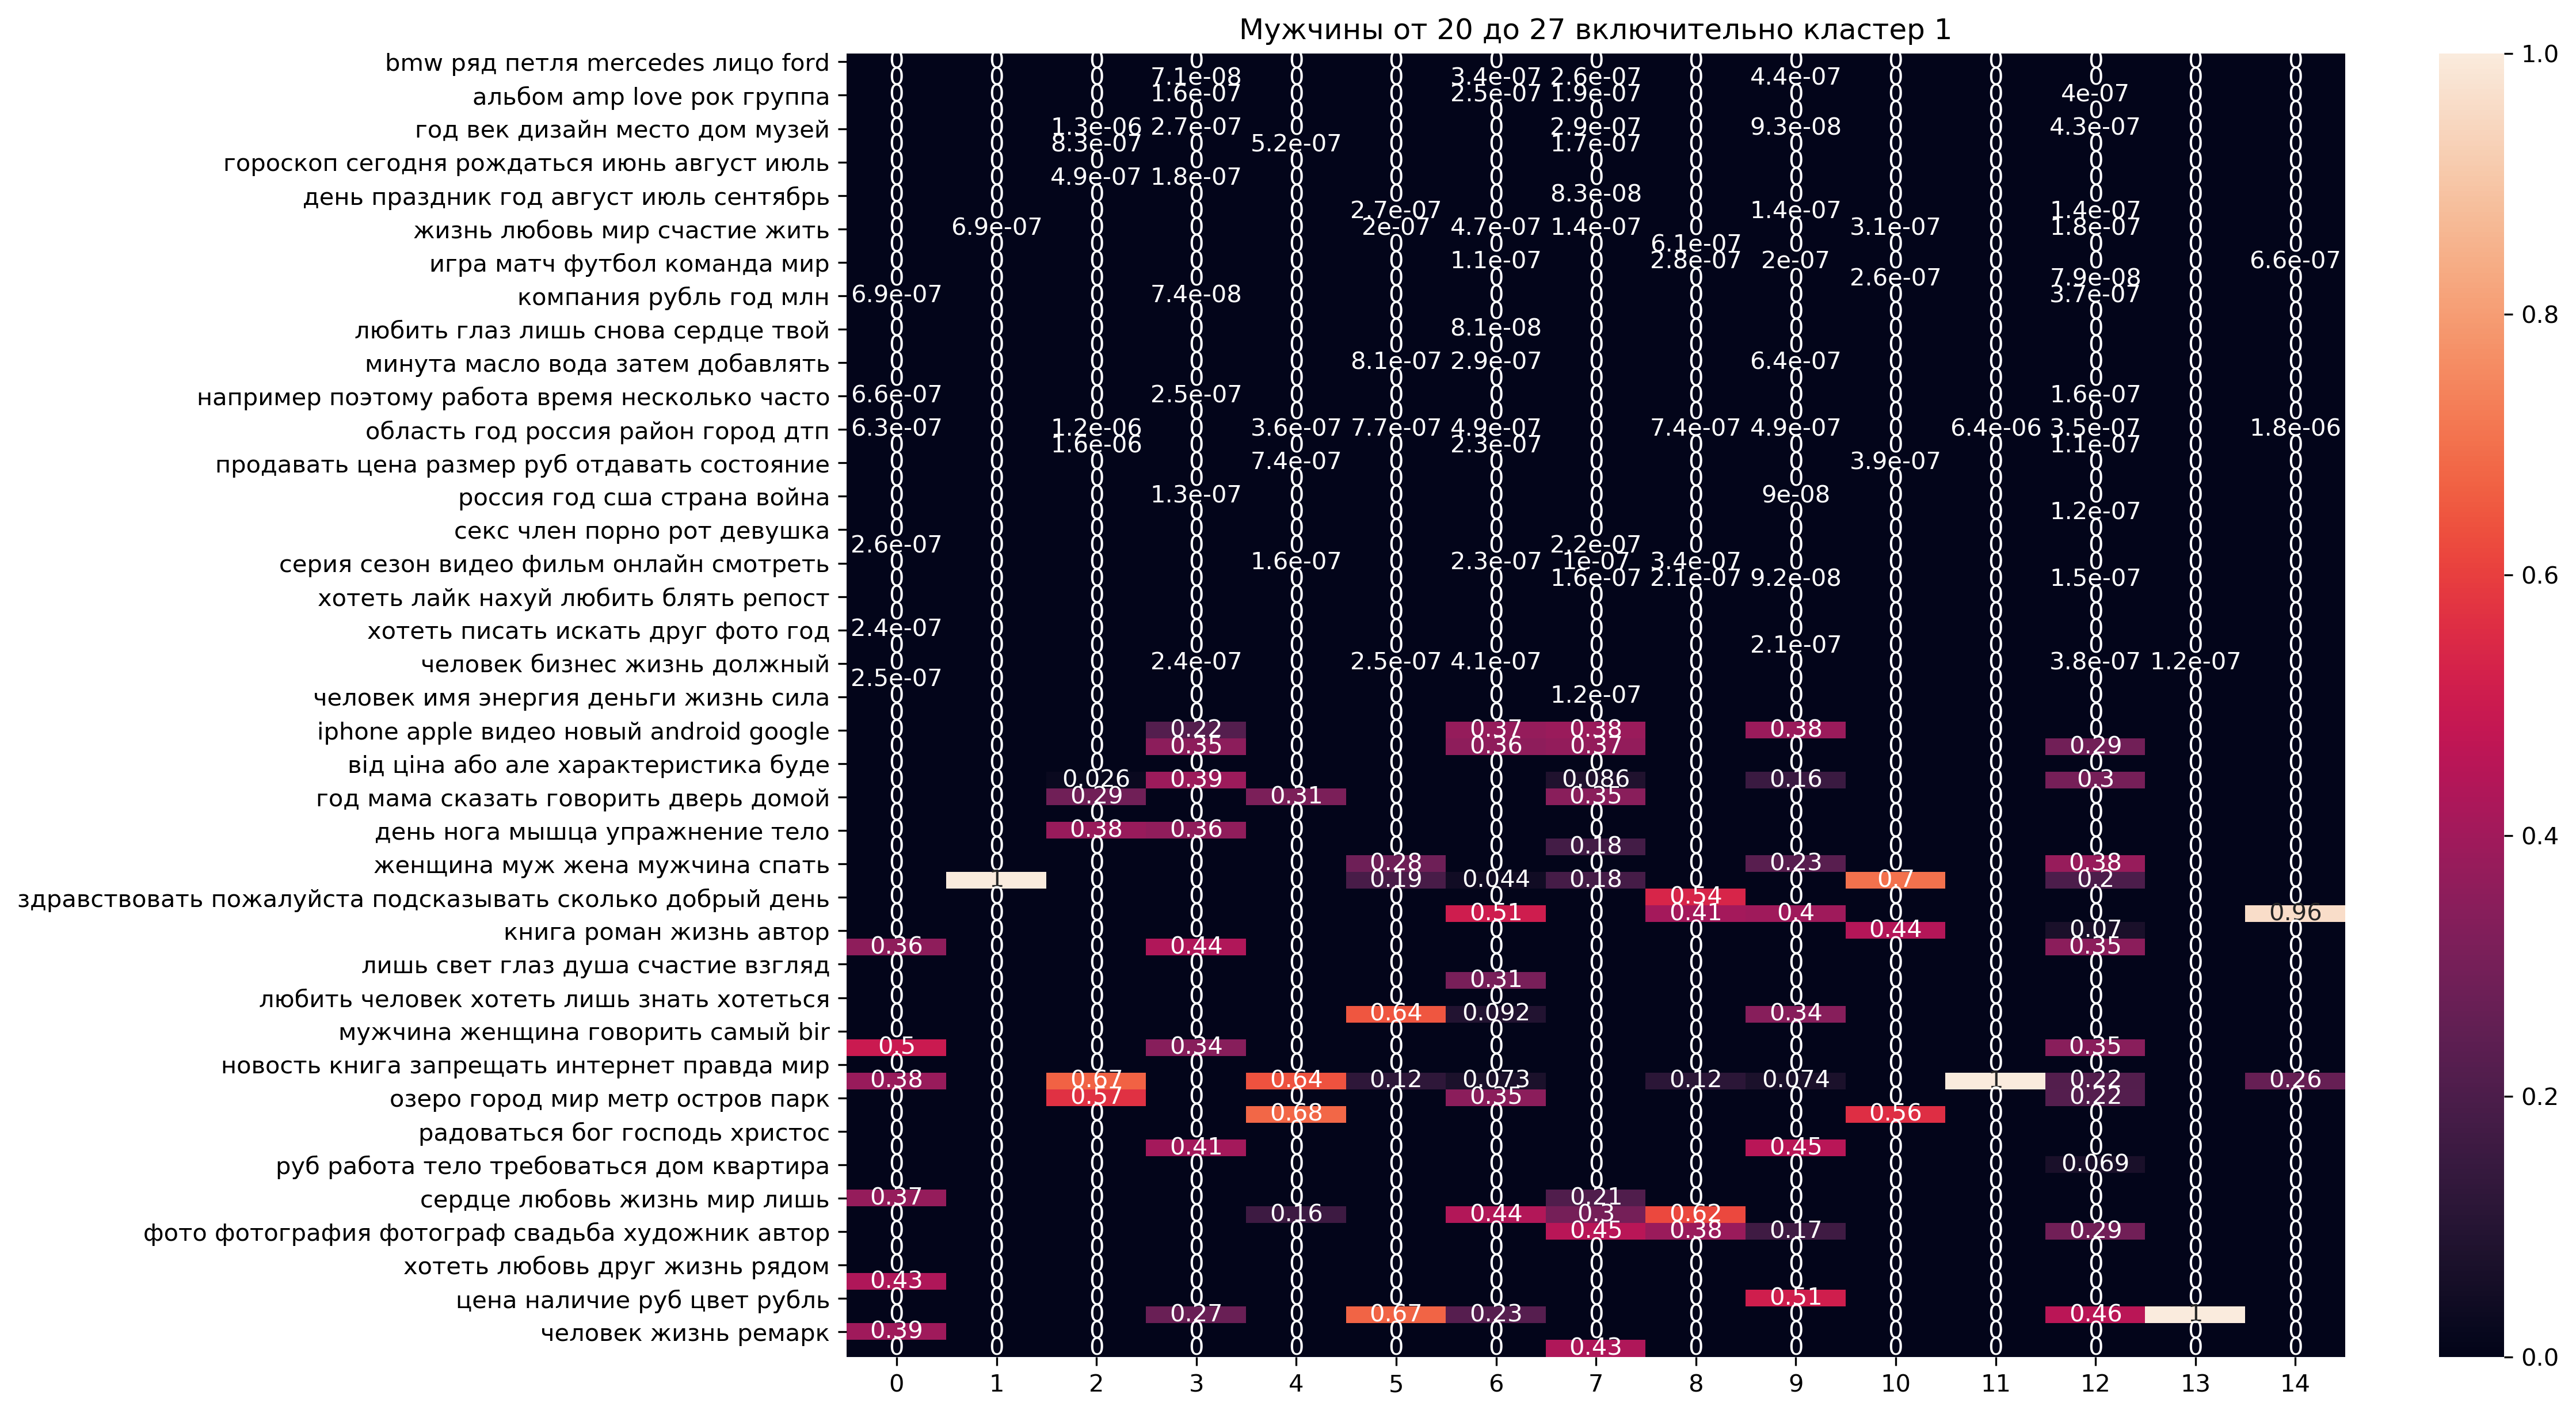

In [240]:
figure(num=None, figsize=(14, 10), dpi=300)
scaler = normalize(grouping['(20.0, 27.0]_1'] \
                   .drop(columns = ['user','age','sex','age_group','count']) \
                   .loc[grouping['(20.0, 27.0]_1']['ag_lables'] == 1] \
                   .drop(columns = 'ag_lables')
                   .iloc[:15,:], norm = 'l2')
a = pd.DataFrame(scaler)
a.columns = grouping['(20.0, 27.0]_1'].drop(columns = ['user','age','sex','age_group','count', 'ag_lables']).columns
ax = plt.axes()
ax.set_title('Мужчины от 20 до 27 включительно кластер 1')
sb.heatmap(a.T, annot = True)

## Женщины от 27 до 36 включительно кластер 1

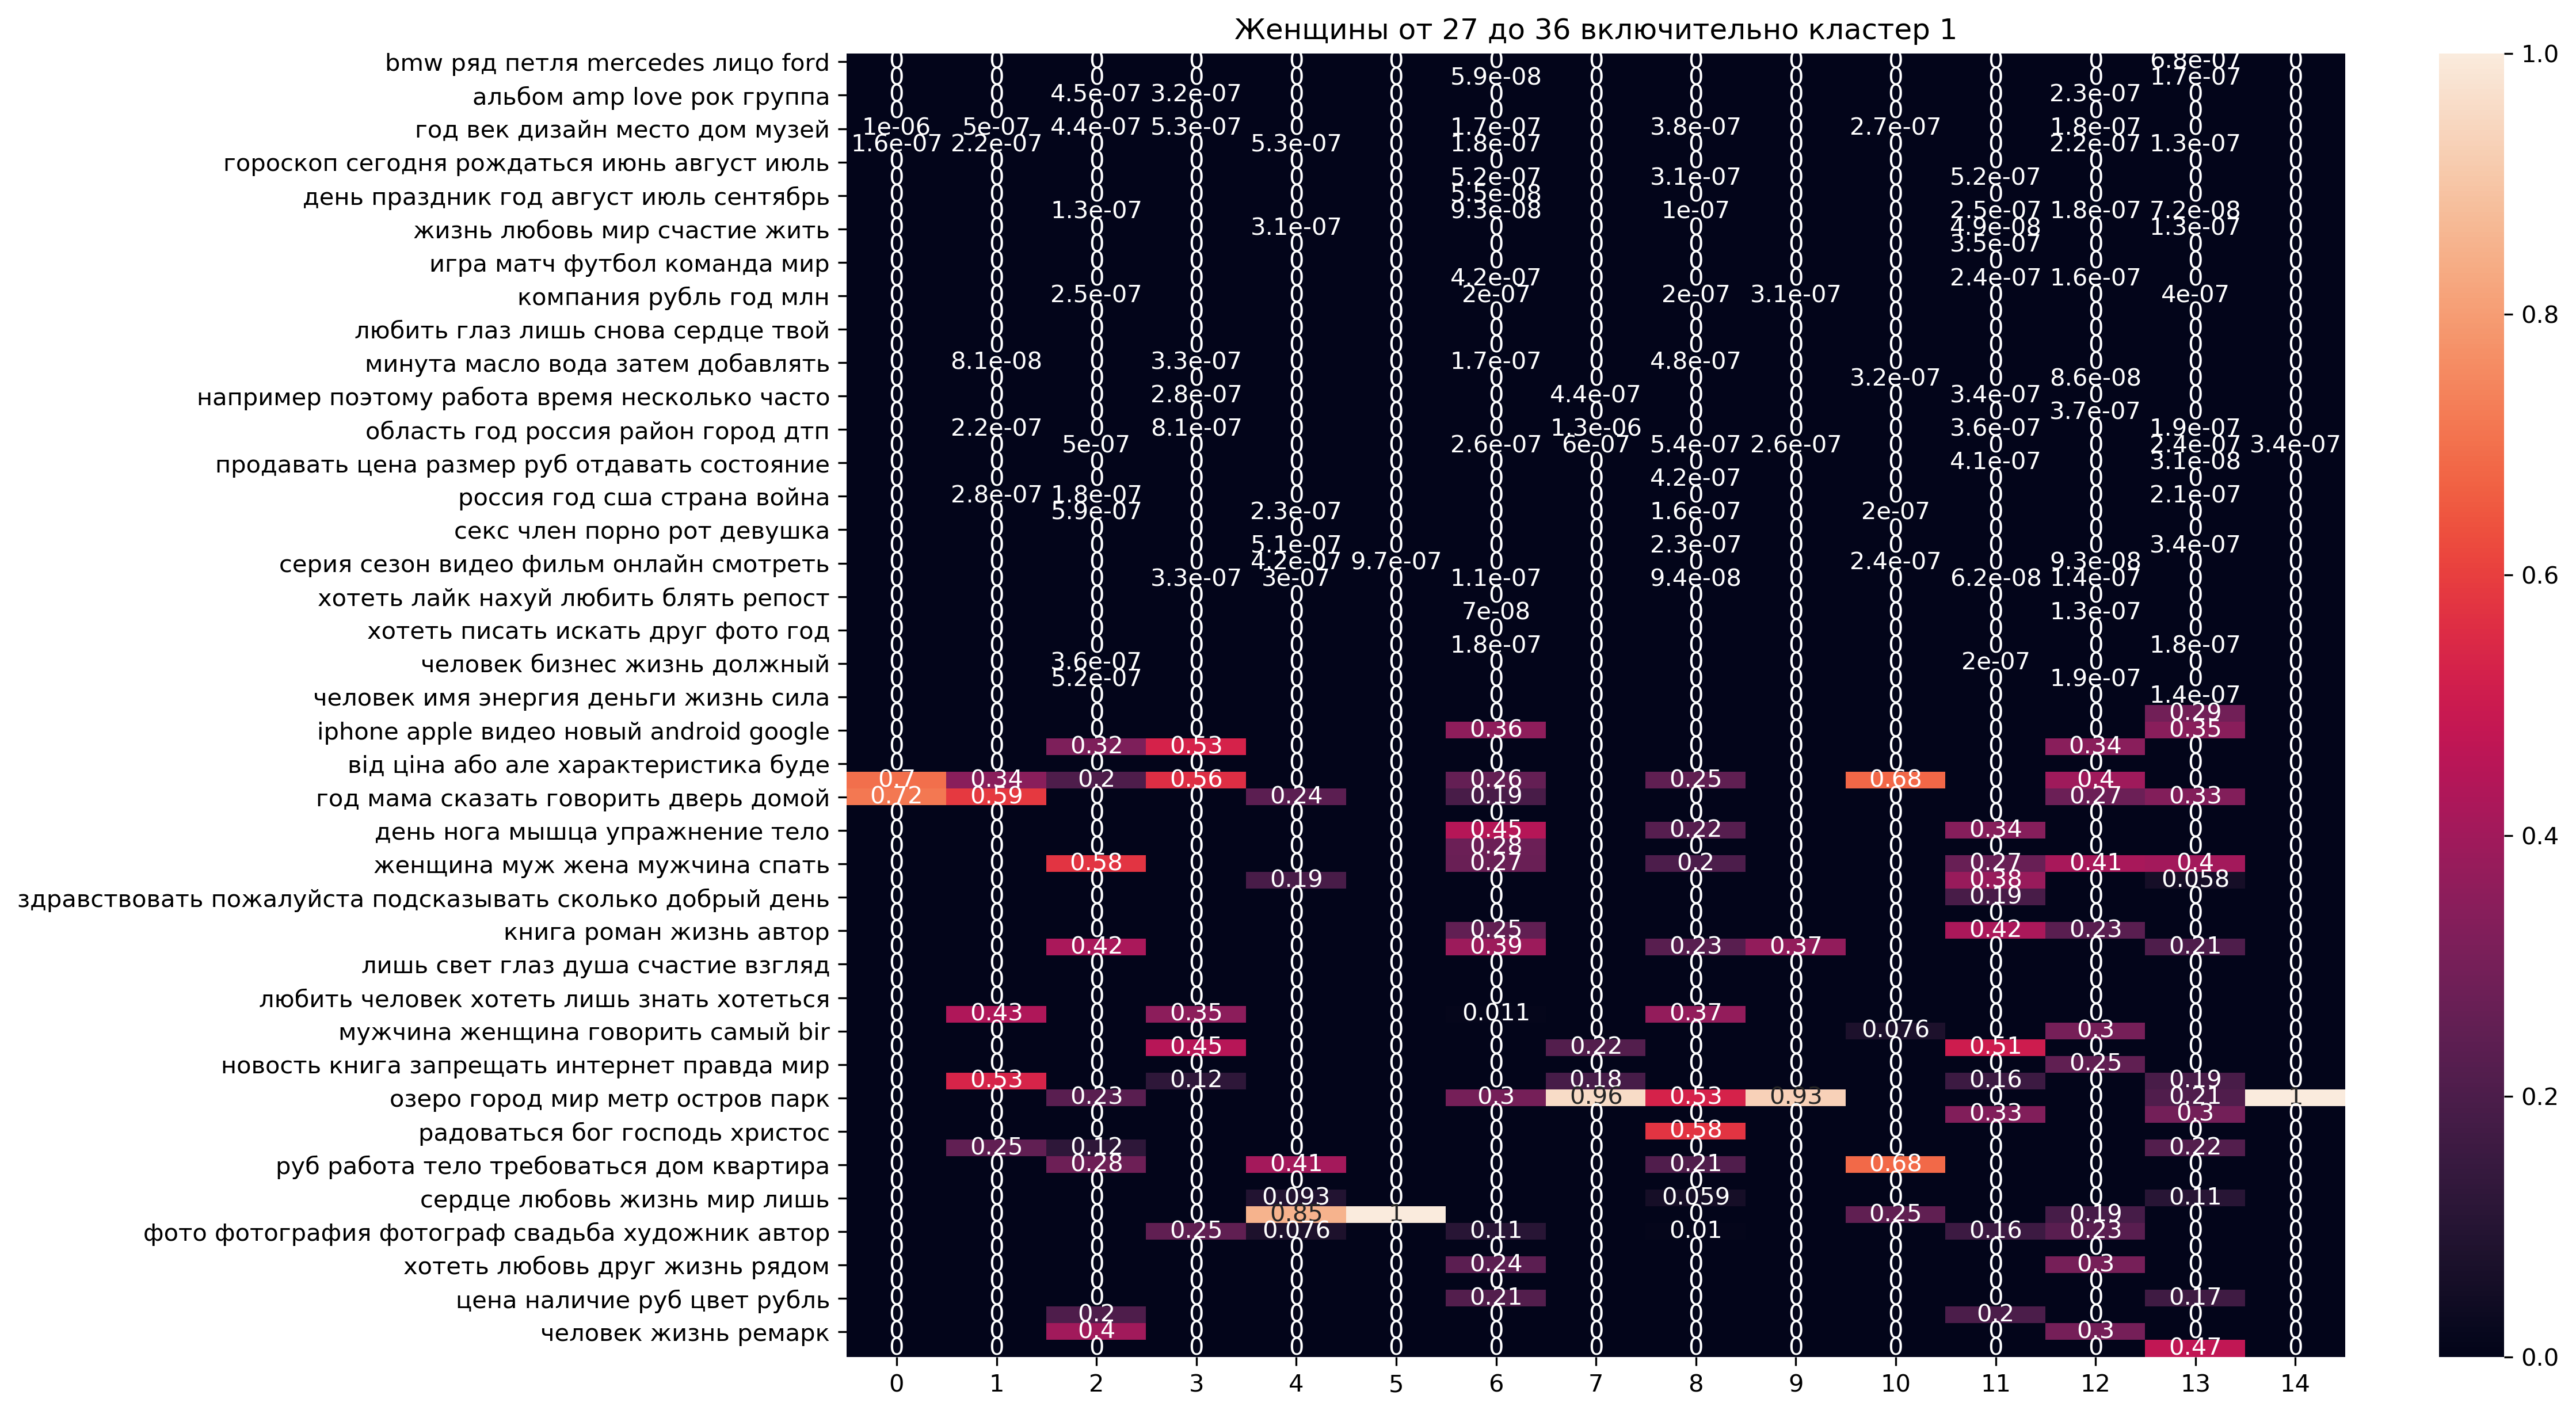

In [241]:
figure(num=None, figsize=(14, 10), dpi=300)
scaler = normalize(grouping['(27.0, 36.0]_0'] \
                   .drop(columns = ['user','age','sex','age_group','count']) \
                   .loc[grouping['(27.0, 36.0]_0']['ag_lables'] == 1] \
                   .drop(columns = 'ag_lables')
                   .iloc[:15,:], norm = 'l2')
a = pd.DataFrame(scaler)
a.columns = grouping['(27.0, 36.0]_0'].drop(columns = ['user','age','sex','age_group','count', 'ag_lables']).columns
ax = plt.axes()
ax.set_title('Женщины от 27 до 36 включительно кластер 1')
sb.heatmap(a.T, annot = True)